In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import os
import random

from functions.parse_data import synth_dataloader
from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from cot_train.utils import MLP5

2024-05-06 09:23:02.943310: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 09:23:02.976091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 09:23:02.976108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 09:23:02.976922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 09:23:02.982616: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)
device = tensor.device

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
#Load data and inspect
df = synth_dataloader('SMHIdata3_newsurf')
df.head(10)

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B08A,Cloud_B09,Cloud_B10,...,Clear_B11,Clear_B12,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
0,0.90032,0.81937,0.88448,0.89139,0.91441,0.92868,0.89153,0.94145,0.38836,0.00412,...,0.49194,0.59996,14.16,68.38,17.39,0.383,3,642,0.127,0.49
1,0.50882,0.48280,0.50241,0.50951,0.53268,0.55200,0.53915,0.57368,0.38162,0.09903,...,0.47565,0.36631,14.46,48.11,134.05,11.760,2,5325,0.129,4.86
2,0.29507,0.30924,0.39888,0.47970,0.70832,0.80920,0.78422,0.88195,0.24766,0.00405,...,0.85240,0.55603,4.06,62.25,110.10,2.322,3,472,0.124,1.17
3,0.49327,0.45420,0.47264,0.47603,0.54040,0.57843,0.53577,0.60191,0.17078,0.00039,...,0.52631,0.28269,11.69,67.75,171.25,14.460,1,9224,0.124,6.23
4,0.42440,0.46368,0.55680,0.66378,0.99693,1.10311,1.06547,1.11276,0.51378,0.00201,...,0.96576,0.84695,2.06,31.39,60.48,4.085,5,51,0.099,0.75
5,0.57723,0.56114,0.58273,0.59771,0.69069,0.74887,0.70231,0.79981,0.37254,0.04232,...,0.60220,0.43186,4.28,31.34,121.12,12.575,2,7450,0.124,4.30
6,0.22774,0.21962,0.21671,0.28301,0.44403,0.49655,0.47319,0.53980,0.09922,0.00088,...,0.75935,0.51803,11.32,77.27,76.27,0.409,2,3915,0.125,1.32
7,0.45606,0.42810,0.52413,0.58870,0.70659,0.74662,0.71055,0.75669,0.35452,0.02653,...,0.84929,0.59307,7.30,71.64,84.00,10.886,1,2477,0.123,0.67
8,0.19051,0.13602,0.11961,0.13199,0.16400,0.17147,0.16864,0.17660,0.08699,0.00207,...,0.19513,0.14873,5.85,80.11,54.84,1.421,5,3165,0.121,0.57
9,0.47401,0.42948,0.48083,0.50990,0.54598,0.56741,0.56494,0.58547,0.36209,0.04438,...,0.53375,0.39198,5.03,70.37,31.65,13.598,2,1139,0.111,0.41


In [4]:
#Set columns for X and y (input/output features)
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Sun_Zenith_Angle']
y_cols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
          'Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']

#Find X and y
X=df[X_cols]
y=df[y_cols]


In [5]:
'''
#Set up paths for importing COT est models
#COT_model_paths = ['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000','smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000','smhi_models3/4/model_it_2000000',
#                   'smhi_models3/5/model_it_2000000','smhi_models3/6/model_it_2000000','smhi_models3/7/model_it_2000000','smhi_models3/8/model_it_2000000','smhi_models3/9/model_it_2000000']

COT_model_paths = ['smhi_models4/0/model_it_2000000','smhi_models4/1/model_it_2000000','smhi_models4/2/model_it_2000000','smhi_models4/3/model_it_2000000','smhi_models4/4/model_it_2000000']



#Initialize and load COT estimation models
COT_est_models = [MLP5(13, 1, apply_relu=True) for _ in range(len(COT_model_paths))]
for i,model in enumerate(COT_est_models):
    model.load_state_dict(torch.load(COT_model_paths[i],map_location=device))

#Create X for COT estimation
X_COTest = X.to_numpy()
#Add noise for fairness
X_COTest= X_COTest + np.random.randn(np.shape(X_COTest)[0],np.shape(X_COTest)[1]) * np.mean(X_COTest,axis=0)*0.03
#Normalize and turn into tensor before input
X_COTest_mu = np.mean(X_COTest,axis=0)
X_COTest_std = np.std(X_COTest,axis=0)
X_COTest_norm = (X_COTest-X_COTest_mu)/X_COTest_std
tX_COTest_norm = torch.Tensor(X_COTest_norm).to(device)
#Make predictions (*50 to denormalize predictions)
COT_preds_total = []
for i,model in enumerate(COT_est_models):
    COT_preds = 50*model(tX_COTest_norm).cpu().detach().numpy()
    #Keep track of ensemble prediction
    if i==0:
        COT_preds_total=COT_preds
    else:
        COT_preds_total=COT_preds_total+COT_preds

COT_preds_total = COT_preds_total/len(COT_est_models)

#Sort into categories instead
t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.015*50 #From Pirinen et. al.

pred_clear = np.zeros(COT_preds_total.shape)
pred_thin = np.zeros(COT_preds_total.shape)
pred_thick = np.zeros(COT_preds_total.shape)

pred_clear[COT_preds_total<t_thin_cloud]=1
pred_thin[(COT_preds_total>=t_thin_cloud)&(COT_preds_total<t_is_cloud)]=1
pred_thick[COT_preds_total>=t_is_cloud]=1

#Create new X including COT dummies
X = X.assign(Clear=pred_clear[:,0])
X = X.assign(Thin=pred_thin[:,0])
X = X.assign(Thick=pred_thick[:,0])

#Update X_cols
X_cols = ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
          'Cloud_B07','Cloud_B08','Cloud_B08A','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12',
          'Sun_Zenith_Angle','Clear','Thin','Thick']

'''

#Separate testdata from rest for 80/10/10 Train/Val/Test split
X_trainval, X_test, y_trainval, y_test=train_test_split(X,y,test_size=0.1,random_state=313)

#Find clear indices in trainval
clear_indices = np.array([])
for i,df_idx in enumerate(X_trainval.index):
    if df['Cloud_Type'][df_idx]==0:
        clear_indices=np.append(clear_indices,i)

#Add noise to X_test, 0 mean with stdev equal to 3% of mean of each feature
np.random.seed(313)
X_test.iloc[:,:13] = X_test.iloc[:,:13] + np.random.randn(np.shape(X_test.iloc[:,:13])[0],np.shape(X_test.iloc[:,:13])[1]) * np.mean(X.iloc[:,:13].to_numpy(),axis=0)*0.03



In [6]:
#Choose if to save models and data, if so set path
save = True
if save:
    test_name = "Ultimate_model"
    main_filepath = 'pytorch_models/'+test_name

#Set up which quantiles to estimate, and find index of estimator (q=0.5)
quantiles=np.array([0.1,0.5,0.9])
est= np.where(quantiles==0.5)[0].item()

#Set up algorithm parameters
val_size=0.1
num_models=10
batch_size=500
nepochs=1000
lr=0.002
noise_ratio = 0.03
early_break=True
no_nodes = 200
clear_noise=True

#Create network
sequence= lambda: nn.Sequential(
    nn.Linear(len(X_cols),no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes,no_nodes),
    nn.ReLU(),
    nn.BatchNorm1d(no_nodes),
    nn.Linear(no_nodes, len(quantiles)*len(y_cols)) #Output dimesion is number of quantiles times number of target variables
)

#Initalize models
models = [QuantileNetwork(quantiles=quantiles) for _ in range(num_models)]

#Train models
for i,model in enumerate(models):
    #Find new train/val splits for each model for robustness
    validation_indices=np.array(random.sample(range(len(X_trainval['Cloud_B02'])), int(len(X['Cloud_B02'])*val_size)))
    train_indices=[i for i in range(len(X_trainval['Cloud_B02'])) if np.any(validation_indices==i)==False]  
    #Fit model with X
    model.fit(X_trainval.to_numpy(),y_trainval.to_numpy(), 
            train_indices=train_indices, 
            validation_indices=validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence(),
            lr=lr,
            noise_ratio=noise_ratio,
            early_break=early_break,
            clear_noise=clear_noise,
            clear_indices=clear_indices)
    
    #Save models if wanted
    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')

#Finally save data if wanted
if save: 
    filepath=main_filepath+'/data'
    os.makedirs(filepath,exist_ok=True)
    #Save datasplits
    X_trainval.to_csv(filepath+'/X_trainval.csv')
    y_trainval.to_csv(filepath+'/y_trainval.csv')
    X_test.to_csv(filepath+'/X_test.csv')
    y_test.to_csv(filepath+'/y_test.csv')

Epoch 361


Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.10it/s]

Training loss [2.480414] Validation loss [2.5157444]
Epoch 362



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.50it/s]

Training loss [2.487669] Validation loss [2.5055454]
Epoch 363



Batch number: 100%|██████████| 320/320 [00:01<00:00, 311.02it/s]

Training loss [2.4771035] Validation loss [2.5037994]
Epoch 364



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.26it/s]

Training loss [2.487282] Validation loss [2.5170047]
Epoch 365



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.38it/s]

Training loss [2.483067] Validation loss [2.5071762]
Epoch 366



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.00it/s]

Training loss [2.4728584] Validation loss [2.507175]
Epoch 367



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.73it/s]

Training loss [2.4813101] Validation loss [2.511864]
Epoch 368



Batch number: 100%|██████████| 320/320 [00:01<00:00, 310.23it/s]

Training loss [2.482846] Validation loss [2.4881587]
Epoch 369



Batch number: 100%|██████████| 320/320 [00:01<00:00, 309.67it/s]

Training loss [2.4789946] Validation loss [2.4996026]


---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 269
With validation loss: 2.471048593521118


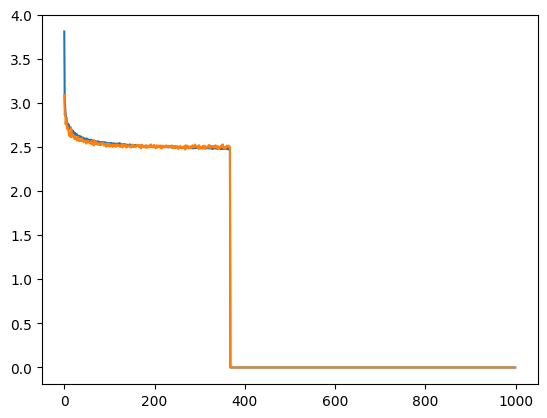

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(model.train_loss.cpu())
plt.plot(model.val_loss.cpu())
plt.show()